In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neural_network import MLPRegressor

import lightgbm as lgb
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from functools import reduce
import joblib


%matplotlib inline
pd.set_option("display.max_columns", None)
%config IPCompleter.greedy = True

In [3]:
route = pd.read_pickle("./route_14__.pkl")
bank_holidays = pd.read_pickle("./bank_holidays__.pkl")
weather = pd.read_pickle("./weather__.pkl")

In [4]:
def route_time_process(df):
    df['hour'] = (df['ActualTime_Arr']//3600) % 24
    return df
route =route_time_process(route)

In [6]:
route[route['hour'] == 23]

,DayOfService,TripID,LineID,RouteID,ProgrNumber,StopPointID,Direction,PlannedTime_Dep,PlannedTime_Arr,ActualTime_Dep,ActualTime_Arr,LastUpdate,hour
15,01-JAN-18 00:00:00,5969512,14,14_16,43,1354,2,85922,82200,83884,83884,08-JAN-18 17:21:10,23
37,01-JAN-18 00:00:00,5969512,14,14_16,44,7589,2,85922,82200,83886,83886,08-JAN-18 17:21:10,23
57,01-JAN-18 00:00:00,5969512,14,14_16,45,7578,2,85922,82200,83942,83942,08-JAN-18 17:21:10,23
99,01-JAN-18 00:00:00,5969512,14,14_16,47,297,2,85922,82200,84596,84187,08-JAN-18 17:21:10,23
121,01-JAN-18 00:00:00,5969512,14,14_16,48,496,2,85922,82200,84690,84690,08-JAN-18 17:21:10,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2669460,29-DEC-18 00:00:00,8577839,14,14_15,50,1043,1,84702,81000,83923,83908,16-JAN-19 18:00:42,23
2669516,29-DEC-18 00:00:00,8577839,14,14_15,51,1044,1,84702,81000,83947,83947,16-JAN-19 18:00:42,23
2669587,29-DEC-18 00:00:00,8590521,14,14_15,73,4486,1,83502,79800,83322,83322,16-JAN-19 18:00:42,23
2669717,29-DEC-18 00:00:00,8589352,14,14_16,34,1169,2,85638,81600,82919,82919,16-JAN-19 18:00:42,23


In [7]:
bank_holidays.head(5)

,date
0,2018-01-01
1,2018-03-19
2,2018-04-02
3,2018-05-07
4,2018-06-04


In [8]:
weather.head(5)

,city_name,lat,lon,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,wind_deg,clouds_all,weather_id,weather_main,weather_description,weather_icon,date,hour
0,Dublin,53.349805,-6.26031,4.15,-6.49,3.84,5.79,990,,,87,12.86,240,40,520,Rain,light intensity shower rain,09n,2018-01-01,0
1,Dublin,53.349805,-6.26031,3.71,-2.28,3.00,5.80,1008,,,75,5.66,240,40,802,Clouds,scattered clouds,03n,2018-01-02,0
2,Dublin,53.349805,-6.26031,5.18,-3.85,5.00,6.66,985,,,87,10.80,260,75,520,Rain,light intensity shower rain,09n,2018-01-03,0
3,Dublin,53.349805,-6.26031,6.06,0.07,5.31,7.29,996,,,87,6.69,230,75,803,Clouds,broken clouds,04n,2018-01-04,0
4,Dublin,53.349805,-6.26031,4.09,-0.08,3.24,5.68,990,,,87,3.60,220,75,803,Clouds,broken clouds,04n,2018-01-05,0


In [9]:
def convert_2_datetime(df, col):
    df[col] = pd.to_datetime(df[col]) 
    return df
route = convert_2_datetime(route, 'DayOfService')
bank_holidays = convert_2_datetime(bank_holidays, 'date')
weather = convert_2_datetime(weather, 'date')

In [10]:
def add_bank_holiday(df, col, bank_holidays, date_col):
    df['bank_holiday'] = np.where(df[col].astype(str).isin(set(list(bank_holidays[date_col].astype(str)))),1,0)
    return df
route = add_bank_holiday(route, 'DayOfService', bank_holidays, 'date')

In [11]:
route[route['bank_holiday'] == 1].tail(10)

,DayOfService,TripID,LineID,RouteID,ProgrNumber,StopPointID,Direction,PlannedTime_Dep,PlannedTime_Arr,ActualTime_Dep,ActualTime_Arr,LastUpdate,hour,bank_holiday
2638508,2018-12-26,8581739,14,14_16,20,1053,2,54331,50400,51309,51309,09-JAN-19 17:30:44,14,1
2638509,2018-12-26,8579398,14,14_16,20,1053,2,79058,75600,76315,76315,09-JAN-19 17:30:44,21,1
2638510,2018-12-26,8579394,14,14_16,21,1054,2,57190,52800,53843,53843,09-JAN-19 17:30:44,14,1
2638511,2018-12-26,8579392,14,14_16,21,1054,2,45331,41400,42137,42137,09-JAN-19 17:30:44,11,1
2638512,2018-12-26,8579398,14,14_16,21,1054,2,79058,75600,76363,76363,09-JAN-19 17:30:44,21,1
2638513,2018-12-26,8580148,14,14_16,22,1036,2,58390,54000,55175,55175,09-JAN-19 17:30:44,15,1
2638514,2018-12-26,8590849,14,14_16,22,1036,2,49531,45600,46996,46984,09-JAN-19 17:30:44,13,1
2638667,2018-12-26,8580854,14,14_16,34,1169,2,41286,37800,39100,39100,09-JAN-19 17:30:44,10,1
2638668,2018-12-26,8581741,14,14_16,34,1169,2,66721,62400,64066,64066,09-JAN-19 17:30:44,17,1
2638669,2018-12-26,8576645,14,14_16,34,1169,2,35333,32400,33774,33774,09-JAN-19 17:30:44,9,1


In [395]:
col = ['ProgrNumber', 'Direction', 'hour',
       'bank_holiday', 'day_of_week','day_of_year', 'journey_time']

def merge_and_clean(df1, df2, col):
    combined_df = pd.merge(df1, df2,  how='inner', left_on=['DayOfService', 'hour'], 
                           right_on = ['date', 'hour'],
                           suffixes=('_route','_weather'))
    combined_df['Direction'] = combined_df['Direction'].astype('int')
    combined_df['day_of_week'] = combined_df['DayOfService'].dt.dayofweek
    combined_df['day_of_year'] = combined_df['DayOfService'].dt.dayofyear
    combined_df['journey_time'] = combined_df['ActualTime_Dep'] - combined_df['PlannedTime_Arr']
    combined_df['journey_time'] = combined_df['journey_time'].apply(lambda x: x if x > 0 else 0)
    combined_df = combined_df[col]
    return combined_df
df = merge_and_clean(route, weather, col)

In [396]:
# df = df[df['Direction'] == 2]
# df.drop(['Direction'], axis=1, inplace = True)

In [397]:
df.head(20)

,ProgrNumber,Direction,hour,bank_holiday,day_of_week,day_of_year,journey_time
0,42,2,9,1,0,1,1505
1,43,2,9,1,0,1,1913
2,43,2,9,1,0,1,1550
3,45,2,9,1,0,1,1993
4,45,2,9,1,0,1,1600
5,46,2,9,1,0,1,2075
6,46,2,9,1,0,1,1711
7,47,2,9,1,0,1,2366
8,47,2,9,1,0,1,1870
9,48,2,9,1,0,1,2433


In [398]:
# fig, ax = plt.subplots(figsize=(24,6))
# ax = sns.countplot(x="weather_main", data=df)
# plt.xticks(rotation=45)

In [399]:
def one_hot_encoding(df, col_list):
    df = pd.get_dummies(df, prefix = col_list, columns = col_list)
    return df

In [400]:
def remove_outlier(df):    
    df = df[np.abs(df["journey_time"]-df["journey_time"].mean())<=(1*df["journey_time"].std())]
    return df

In [401]:
# df = one_hot_encoding(df, ['weather_main'])
print ("Shape Of The Before Ouliers: ",df.shape)
df = remove_outlier(df)
print ("Shape Of The After Ouliers: ",df.shape)

Shape Of The Before Ouliers:  (2678410, 7)
Shape Of The After Ouliers:  (2678410, 7)


In [402]:
# fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(20,16))
# sns.boxplot(data=df,y="journey_time",x="bank_holiday",orient="v",ax=axes[0][0])
# sns.boxplot(data=df,y="journey_time",x="day_of_week",orient="v",ax=axes[0][1])
# sns.boxplot(data=df,y="journey_time",x="day_of_year",orient="v",ax=axes[1][0])
# sns.boxplot(data=df,y="journey_time",x="hour",orient="v",ax=axes[1][1])
# axes[0][0].set(ylabel='bank_holiday')
# axes[0][1].set(xlabel='day_of_week', ylabel='journey_time')
# axes[1][0].set(xlabel='day_of_year', ylabel='journey_time')
# axes[1][1].set(xlabel='hour', ylabel='journey_time')

In [403]:
#Slow runnimg

#Finding distribution between different time
# fig, axes = plt.subplots(ncols=2, figsize=(16,6))
# sns.barplot(data=df, y = 'journey_time', x = 'hour', ax=axes[0])
# sns.barplot(data=df, y = 'journey_time', x = 'day_of_week', ax=axes[1])

In [404]:
#Finding correlation of continuous features
# col = ['hour', 'bank_holiday',
#        'temp', 'pressure', 'humidity', 'wind_speed', 'clouds_all',
#        'day_of_week', 'day_of_year', 'journey_time']
# corrMatt = df[col].corr()
# mask = np.array(corrMatt)
# mask[np.tril_indices_from(mask)] = False
# fig,ax= plt.subplots(figsize=(16,12))
# sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)
# plt.show()

In [405]:
# fig, axes = plt.subplots(nrows=3,ncols=2, figsize=(16,12))
# sns.distplot(df["temp"],ax=axes[0][0])
# sns.distplot(df["pressure"],ax=axes[0][1])
# sns.distplot(df["humidity"],ax=axes[1][0])
# sns.distplot(df["wind_speed"],ax=axes[1][1])
# sns.distplot(df["clouds_all"],ax=axes[2][0])
# sns.distplot(df["journey_time"],ax=axes[2][1])

# axes[0][0].set(xlabel='temp', ylabel='d')
# axes[0][1].set(xlabel='pressure', ylabel='d')
# axes[1][0].set(xlabel='humidity', ylabel='d')
# axes[1][1].set(xlabel='wind_speed', ylabel='d')
# axes[2][0].set(xlabel='clouds_all', ylabel='d')
# axes[2][1].set(xlabel='journey_time', ylabel='d')

In [406]:
def time_transform(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)
    df = df.drop([col], axis = 1)
    return df

In [407]:
df = time_transform(df, 'day_of_week', 7)
df = time_transform(df, 'hour', 24)

In [408]:
y = df['journey_time']
x = df.loc[:, df.columns != 'journey_time']

In [409]:
size = len(x) * 9 //10 
x_train, x_test = x[:size], x[size:]
y_train, y_test = y[:size], y[size:]
print(size)

2410569


In [410]:
x_train.dtypes

ProgrNumber          int64
Direction            int64
bank_holiday         int64
day_of_year          int64
day_of_week_sin    float64
day_of_week_cos    float64
hour_sin           float64
hour_cos           float64
dtype: object

In [411]:
%%time
#Model validation
lgb_turned = lgb.LGBMRegressor()
lgb_turned.fit(x_train, y_train)
scores=cross_val_score(lgb_turned, x_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
print("- RMSE: {:.5f}".format(np.mean(scores)))

- RMSE: -367.21029
CPU times: user 3min 10s, sys: 4.21 s, total: 3min 14s
Wall time: 30 s


In [412]:
model_name = 'lgbm_model.pkl'
joblib.dump(lgb_turned, model_name)

['lgbm_model.pkl']

In [413]:
%%time
model = joblib.load(model_name)
y_prediction = model.predict(x_test)

CPU times: user 2.23 s, sys: 17.1 ms, total: 2.25 s
Wall time: 306 ms


In [414]:
y_test = y_test.reset_index()["journey_time"]
metrics.mean_squared_error(y_test, y_prediction, squared=False)

476.2896044557676

In [415]:
_prediction = pd.Series(y_prediction)

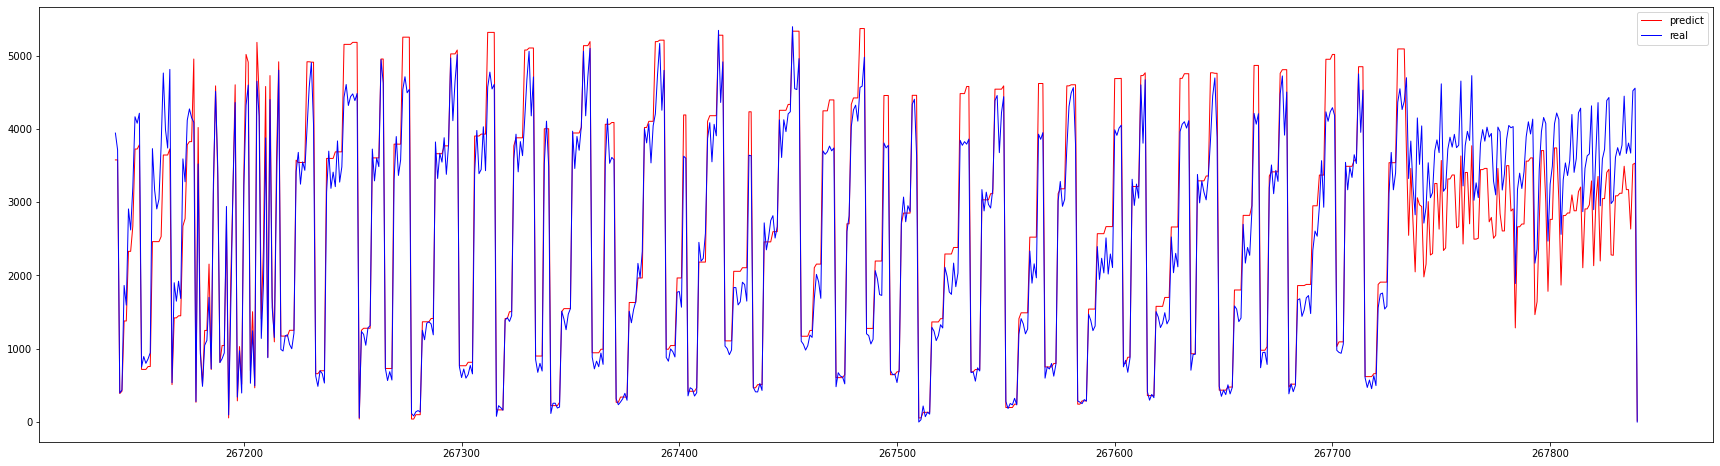

In [416]:
fig, ax = plt.subplots(figsize=(30,8))
plt.plot(_prediction[-700:], linewidth=1, color = 'red', label = 'predict')
plt.plot(y_test[-700:], linewidth=1, color = 'blue', label = 'real')
plt.legend()
plt.show()

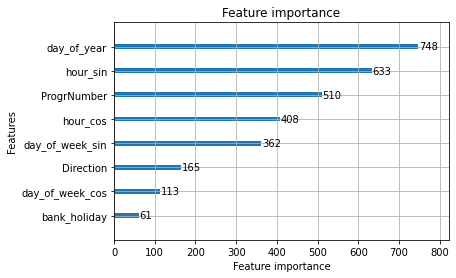

In [345]:
lgb.plot_importance(model)

In [189]:
from sklearn.neighbors import NearestCentroid

In [62]:
x_valued = x #returns a numpy array
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(x_valued)

In [63]:
size = len(x) * 9 //10 
x_train_scaled, x_test_scaled = x_scaled[:size], x_scaled[size:]
y_train, y_test = y[:size], y[size:]
print(size)

2409579


In [64]:
%%time

#Model validation
nn = MLPRegressor(hidden_layer_sizes=(128, 64, 32, 16) ,random_state=42, max_iter=100, batch_size=640, verbose=True)
nn.fit(x_train, y_train)
# scores=cross_val_score(bayes, x_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
# print("- RMSE: {:.5f}".format(np.mean(scores)))

CPU times: user 28.2 s, sys: 2.91 s, total: 31.1 s
Wall time: 8.05 s


/Users/pie_trick/Desktop/Semester3/venv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPRegressor(batch_size=640, hidden_layer_sizes=(128, 64, 32, 16), max_iter=100,
             random_state=42, verbose=True)

In [129]:
model_name = 'nn_model.pkl'
joblib.dump(nn, model_name)

['nn_model.pkl']

In [130]:
%%time
model = joblib.load(model_name)
y_prediction = model.predict(x_test)

CPU times: user 4.23 s, sys: 1.03 s, total: 5.27 s
Wall time: 1.35 s


In [131]:
y_test = y_test.reset_index()["journey_time"]
metrics.mean_squared_error(y_test, y_prediction, squared=False)

518.9076994589993

In [132]:
_prediction = pd.Series(y_prediction)

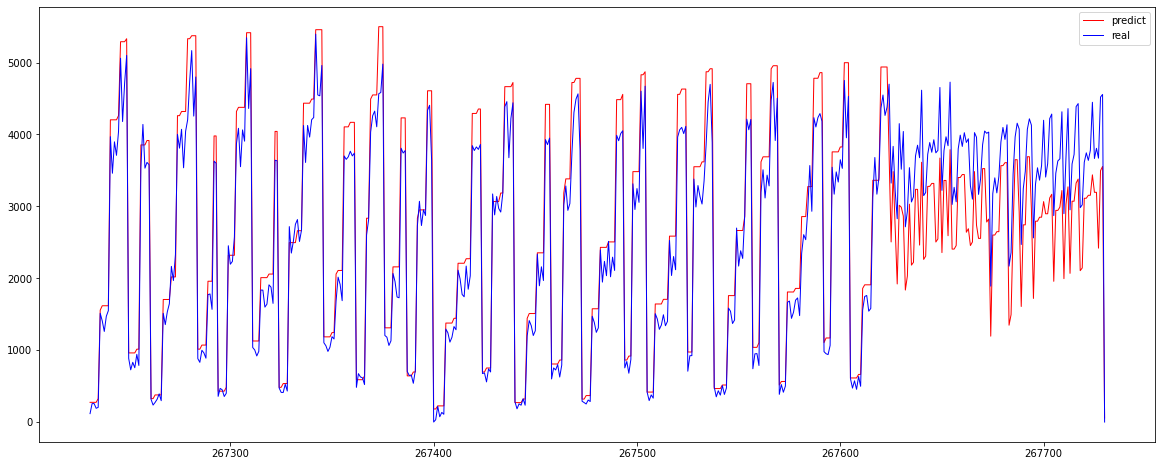

In [133]:
fig, ax = plt.subplots(figsize=(20,8))
plt.plot(_prediction[-500:], linewidth=1, color = 'red', label = 'predict')
plt.plot(y_test[-500:], linewidth=1, color = 'blue', label = 'real')
plt.legend()
plt.show()